In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression

## Complex Model

In [4]:
#prepare the data for modeling
df = pd.read_csv('./data-set/sales_train.csv')
#rename item_cnt_day column
df.rename(columns={'item_cnt_day': 'item_count'}, inplace=True)
#removes duplicates
df.drop_duplicates(inplace=True)
#outlier treatment
df = df[(df['item_count'] > 0) & (df['item_count'] < 307980)]
df = df[df['item_count'] < 1000]
#handles incorrect data
df = df[(df['item_price'] > 0) & (df['item_price'] < 100000)]
#converts date column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
#convert date to year-month format
df['year-month'] = df['date'].dt.strftime('%Y-%m')
#drop date column and item_price column
df.drop(columns=['date', 'item_price'], inplace=True)
# group features
df_train_group = df.groupby(['year-month', 'shop_id', 'item_id']).sum().reset_index()
# pivot table
df = df_train_group.pivot_table(index=['shop_id', 'item_id'], columns='year-month', values='item_count', fill_value=0).reset_index()

print(df.head(10))
print(df.shape)
print(df.info())

year-month  shop_id  item_id  2013-01  2013-02  2013-03  2013-04  2013-05  \
0                 0       30        0       31        0        0        0   
1                 0       31        0       11        0        0        0   
2                 0       32        6       10        0        0        0   
3                 0       33        3        3        0        0        0   
4                 0       35        1       14        0        0        0   
5                 0       36        0        1        0        0        0   
6                 0       40        0        1        0        0        0   
7                 0       42        0        1        0        0        0   
8                 0       43        1        0        0        0        0   
9                 0       49        0        2        0        0        0   

year-month  2013-06  2013-07  2013-08  ...  2015-01  2015-02  2015-03  \
0                 0        0        0  ...        0        0        0   
1     

In [5]:
# Create X and y variables for train and test sets
X = df[df.columns[:-1]]
y = df[df.columns[-1]]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(339277, 35)
(84820, 35)
(339277,)
(84820,)


In [8]:
#creating evaluation metrics
scores_and_names = []

# Create a function to evaluate the model
def evaluate_the_model(y_true, y_pred, model_name, model, index=None):
    if not isinstance(y_true, pd.Series):
        if index is None:
            index = range(len(y_true))
        y_true = pd.Series(y_true, index=index)

    # Calculate the MAE
    mae = mean_absolute_error(y_true, y_pred)
    print(f"MAE for {model_name}: {mae:.5f}")

    # Calculate the MSE
    mse = mean_squared_error(y_true, y_pred)
    print(f"MSE for {model_name}: {mse:.5f}")

    # Calculate the RMSE
    rmse = np.sqrt(mse)
    print(f"RMSE for {model_name}: {rmse:.5f}")

    #calculate r2 score
    r2 = r2_score(y_true, y_pred)
    print(f"R2 for {model_name}: {r2:.5f}")

    # Plot the predictions vs. the actual values
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(x=y_true.index, y=y_true, label='Actual Values')
    sns.lineplot(x=y_true.index, y=y_pred, label='Predicted Values')
    plt.title(f'Predictions vs. Actual Values ({model_name})')
    plt.xlabel('Observation')
    plt.ylabel('Item Count')
    plt.legend()
    plt.show()

    scores_and_names.append((model_name, rmse))

    

c:\Users\srume\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MAE for Stacked Model: 0.13173
MSE for Stacked Model: 1.42800
RMSE for Stacked Model: 1.19499
R2 for Stacked Model: 0.44840


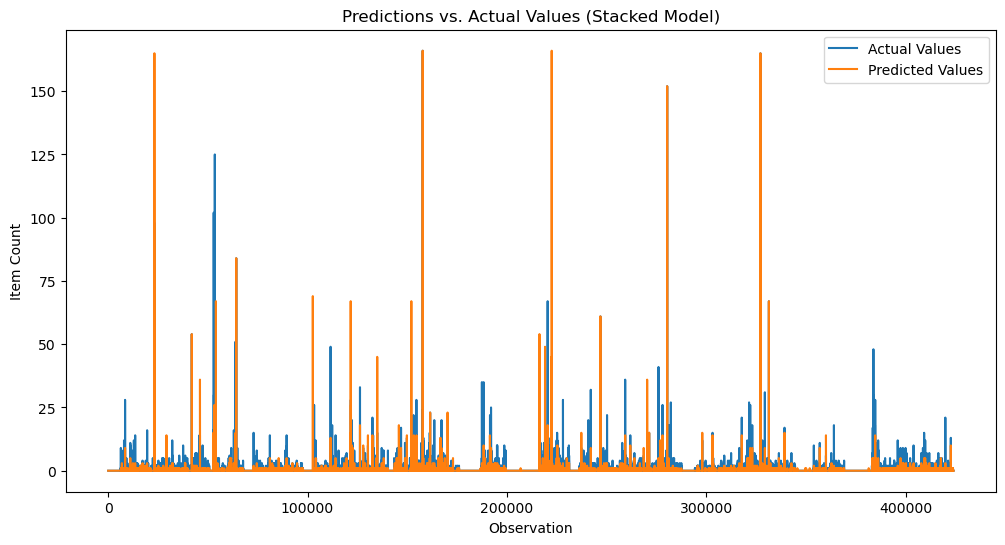

In [9]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

et = ExtraTreesRegressor()
et.fit(X_train, y_train)
et_pred = et.predict(X_test)

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

log_reg = LogisticRegression()

stacked_data = np.column_stack((rf_pred, et_pred, xgb_pred))

log_reg.fit(stacked_data, y_test)

rf_new_pred = rf.predict(X_test)
et_new_pred = et.predict(X_test)
xgb_new_pred = xgb.predict(X_test)

stacked_new_data = np.column_stack((rf_new_pred, et_new_pred, xgb_new_pred))

final_pred = log_reg.predict(stacked_new_data)

evaluate_the_model(y_test, final_pred, 'Stacked Model 1', log_reg)

                          Model          RMSE
3                 Random Forest  1.047522e+00
6                   Extra Trees  1.052919e+00
0                 Decision Tree  1.182239e+00
2           K-Nearest Neighbors  1.265051e+00
7                       XGBoost  1.300267e+00
9              Lasso Regression  1.454596e+00
12               Bayesian Ridge  1.547795e+00
8              Ridge Regression  1.547984e+00
1             Linear Regression  1.547985e+00
10                        ARIMA  1.608982e+00
4           Logistic Regression  1.616978e+00
13       Support Vector Machine  1.616978e+00
11                     AdaBoost  2.056862e+00
5   Stochastic Gradient Descent  7.710156e+15

c:\Users\srume\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MAE for Stacked Model: 0.15218
MSE for Stacked Model: 2.11464
RMSE for Stacked Model: 1.45418
R2 for Stacked Model: 0.18316


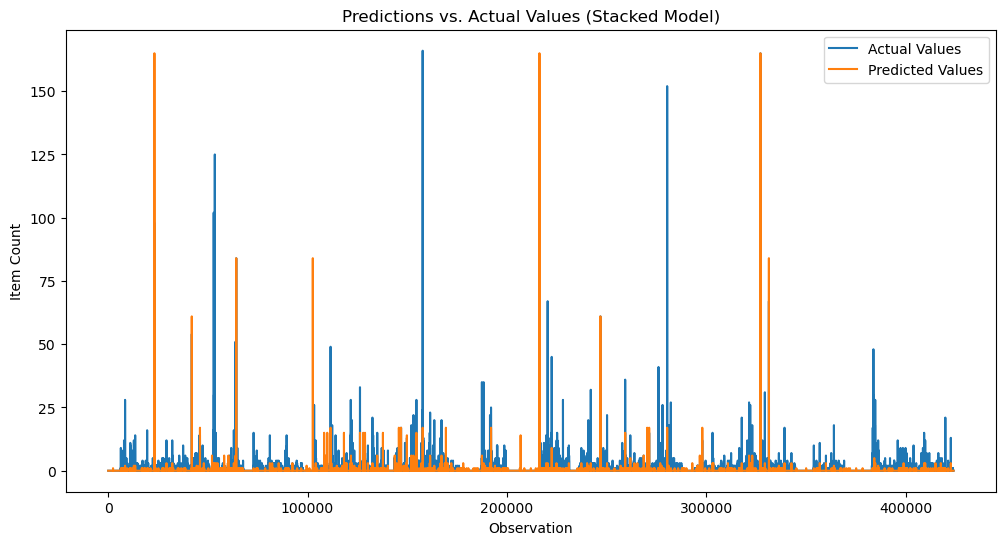

In [10]:
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train.values, y_train.values)
knn_pred = knn.predict(X_test.values)

lasso = Lasso()
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

log_reg = LogisticRegression()

stacked_data = np.column_stack((svm_pred, knn_pred, lasso_pred))

log_reg.fit(stacked_data, y_test)

svm_new_pred = svm.predict(X_test)
knn_new_pred = knn.predict(X_test.values)
lasso_new_pred = lasso.predict(X_test)

stacked_new_data = np.column_stack((svm_new_pred, knn_new_pred, lasso_new_pred))

final_pred = log_reg.predict(stacked_new_data)

evaluate_the_model(y_test, final_pred, 'Stacked Model 2', log_reg)